In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jaxmao.layers import Conv2D, Dense, BatchNorm, ReLU, Flatten, StableSoftmax
from jaxmao.modules import Module
from jaxmao.optimizers import GradientDescent
from jaxmao.losses import CategoricalCrossEntropy
from jaxmao.metrics import Accuracy, Precision, Recall

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
seed = 42
key = jax.random.PRNGKey(seed)

I0000 00:00:1697797605.982189   89282 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
data = datasets.load_digits()
image, label = data['images'], data['target']

X_train, X_test, y_train, y_test = train_test_split(image, label, test_size=0.2, random_state=seed)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

enc = OneHotEncoder(sparse_output=False)
y_train_enc = enc.fit_transform(np.expand_dims(y_train, axis=1))
y_test_enc = enc.transform(np.expand_dims(y_test, axis=1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 8, 8, 1), (360, 8, 8, 1), (1437,), (360,))

In [4]:
class DigitClassifier(Module):
    def __init__(self):
        super().__init__()
        self.add('conv1', Conv2D(1, 8, (3, 3), 1))
        self.add('bn1', BatchNorm(8, axis_mean=(0,1,2)))
        self.add('conv2', Conv2D(8, 2, (1, 1), 1))
        self.add('bn2', BatchNorm(2, axis_mean=(0,1,2)))
        self.add('flatten', Flatten())
        self.add('fc1', Dense(128, 64))
        self.add('bn3', BatchNorm(64))
        self.add('fc2', Dense(64, 10, activation=StableSoftmax()))

        self.add('relu', ReLU())
        
    def forward(self, params, x, state):
        x, state = self.apply(params, x, 'conv1', state)
        x, state = self.apply(params, x, 'bn1', state)
        x = ReLU()(x)
        x, state = self.apply(params, x, 'conv2', state)
        x, state = self.apply(params, x, 'bn2', state)
        x = ReLU()(x)
        x, state = self.apply(params, x, 'flatten', state)
        x, state = self.apply(params, x, 'fc1', state)
        x, state = self.apply(params, x, 'bn3', state)
        x = ReLU()(x)
        x, state = self.apply(params, x, 'fc2', state)
        return x, state

clf = DigitClassifier()
clf.init_params(key)
out, state = clf.pure_forward(clf.params, X_train[:200], clf.state)

summary = clf.summarize()

layer                output shape         #'s params           #'s states          
conv1                (200, 8, 8, 8)       80                   0                   
bn1                  (200, 8, 8, 8)       16                   16                  
conv2                (200, 8, 8, 2)       18                   0                   
bn2                  (200, 8, 8, 2)       4                    4                   
flatten              (200, 128)           0                    0                   
fc1                  (200, 64)            8256                 0                   
bn3                  (200, 64)            128                  128                 
fc2                  (200, 10)            650                  0                   
total parameters: 9152


In [5]:
clf.forward = jax.jit(clf.forward)
clf.pure_forward = jax.jit(clf.pure_forward)

out, state = clf.pure_forward(clf.params, X_train[:200], clf.state)
out.shape, type(out), type(state)

((200, 10), jaxlib.xla_extension.ArrayImpl, dict)

In [6]:
from sklearn.utils import shuffle

criteria = CategoricalCrossEntropy()
criteria.calculate_loss = jax.jit(criteria.calculate_loss)
def loss_fn(model, params, x_true, y_true, state,
            criteria
            ):
    y_pred, new_state = model.pure_forward(params, x_true, state)
    loss = criteria(y_pred, y_true)
    return loss, new_state

val_grad_loss_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)
def training_loop(
    model, optimizer, x_true, y_true,
    epochs, lr=0.01, batch_size=16
):
    num_batch = len(x_true) // batch_size 
    for epoch in range(epochs):
        losses = 0.0
        x_true, y_true = shuffle(x_true, y_true)
        for n in range(num_batch):
            batch_x = x_true[n*batch_size:(n+1)*batch_size]
            batch_y = y_true[n*batch_size:(n+1)*batch_size]
            (loss, new_state), gradients = val_grad_loss_fn(model, model.params, 
                                                            batch_x, 
                                                            batch_y, 
                                                            model.state, 
                                                            criteria)
            losses = losses + loss
            model.params, optim_state = optimizer.step(model.params, gradients, lr=lr)
            model.update_state(new_state)
        
        accuracy = Accuracy()(model(model.params, batch_x), batch_y.argmax(axis=1))
        print('epoch {}: {}, {}'.format(epoch, losses/num_batch, accuracy))

In [7]:
optimizer = GradientDescent()
epochs = 1
lr = 0.01

training_loop(clf, 
              optimizer, 
              X_train, 
              y_train_enc, 
              epochs=epochs, lr=lr, batch_size=16
              )

epoch 0: 2.3588922023773193, 0.1015625


In [8]:
# clf.eval(X_test[:20], y_test[:20])

In [9]:
y_pred = clf(clf.params, X_test)
for name, metric in clf.metrics.items():
    print(name, metric(y_pred, y_test_enc))

In [10]:
Accuracy()(y_pred, y_test)

Array(0.10335648, dtype=float32)

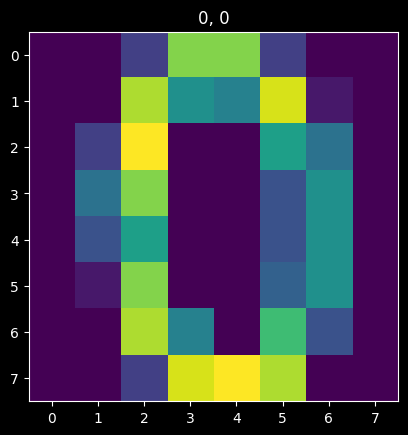

In [11]:
index = np.random.randint(0, len(X_test))
plt.imshow(X_test[index])
plt.title(f'{y_test[index]}, {y_pred[index].argmax()}')
plt.show()

# using .fit()!!!

In [12]:
clf = DigitClassifier()
clf.init_params(key)

out = clf(clf.params, X_test)
out.shape

(360, 10)

In [13]:
clf.compile(
    loss_fn=CategoricalCrossEntropy(),
    optimizer=GradientDescent(),
    metrics=[Accuracy(), Precision(), Recall()]
)

In [14]:
epochs = 5
clf.fit(X_train, y_train_enc, lr=0.01, epochs=epochs,
        X_val=X_test[:20], y_val=y_test_enc[:20])

epoch     avg_loss       accuracy        precision       recall         
0          2.6675         0.1328          0.6269          0.6818          
           2.181           0.3             1.0             1.0            

1          1.8992         0.3452          0.7955          0.8636          
           1.573           0.45            1.0             1.0            

2          1.4684         0.5604          0.9545          0.9773          
           1.231           0.65            1.0             1.0            

3          1.2424         0.6499          0.9091          0.8977          
           1.032           0.75            1.0             1.0            

4          1.0735         0.7053          0.9318          0.9261          
           0.8976          0.75            1.0             1.0            



In [15]:
clf.eval(X_test, y_test_enc)

{'loss': Array(0.93523115, dtype=float32),
 'accuracy': Array(0.78888893, dtype=float32),
 'precision': Array(1., dtype=float32),
 'recall': Array(1., dtype=float32)}

In [19]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
enc.fit(y_true.reshape(-1,1))

OneHotEncoder(sparse_output=False)

In [26]:
y_true = np.array([0]*90 + [1]*10)  # 90 Not Spam and 10 Spam emails
y_pred = np.array([0]*70 + [1]*20 + [1]*10)  # 70 Not Spam correctly classified, 20 Not Spam incorrectly classified as Spam, 10 Spam correctly classified
Accuracy()(y_pred, y_true), Precision()(y_pred, y_true), Recall()(y_pred, y_true)

(0.66, 0.1, 0.3)

In [21]:
clf.metrics['accuracy'](y_pred, y_true), clf.metrics['precision'](y_pred, y_true), clf.metrics['recall'](y_pred, y_true),

(0.66, 0.1, 0.3)